In [1]:
import matplotlib.pyplot as plt
import torch
import os
from pathlib import Path
from importlib import reload

os.chdir("..")  # Change root dir to project folder
os.getcwd()

'/home/bbd0953/diffusion/src'

# PyBDSF Examples

In [2]:
import numpy as np
import analysis.bdsf_evaluation as bdsfeval
import utils.paths as paths
from utils.data_utils import EvaluationDataset
import plotting.paper_plots as pplt

img_path = Path(paths.LOFAR_SUBSETS["0-clip"])

dset = EvaluationDataset(img_path)

metrics_dict = bdsfeval.get_metric_dict(img_path)
model_imgs = np.array(
    [a for a in metrics_dict["model_gaus_arr"]]).transpose(0, 2, 1)

Loading images...
Data set initialized.
Found existing distribution file for 0-clip.hdf5.


## Residuals Examples

In [47]:
dset.transform_max_vals()

Max values transformed with Box-Cox transformation ([-0.22999055]).


[18603, 46988, 46509, 34986, 84385]
0.1161807
0.1161807
0.1161807
0.1161807
0.1161807


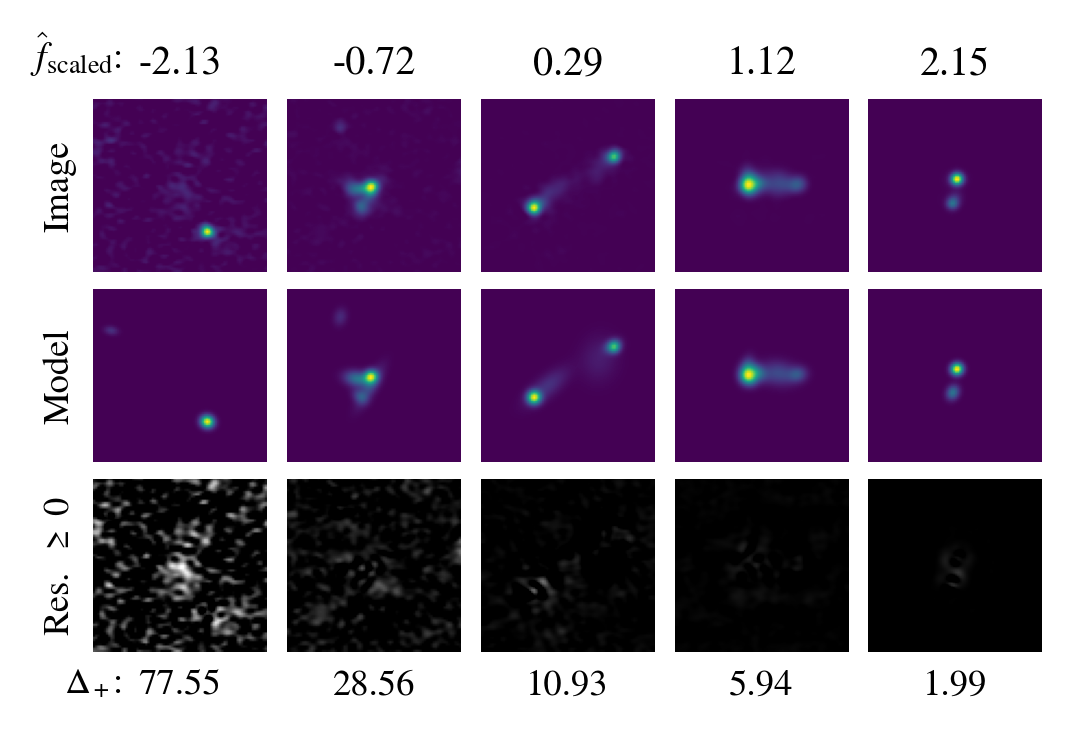

In [91]:
n_examples = 5
_, bins = np.histogram(dset.max_values_tr, bins=np.linspace(-3.5, 3.5, n_examples + 1))
bin_idxs = np.digitize(dset.max_values_tr, bins)
# idxs = [np.random.choice(np.where(bin_idxs == i)[0]) for i in range(1, n_examples + 1)]

print(idxs)

img_arr = np.array([dset[idx].squeeze() for idx in idxs])
model_arr = model_imgs[idxs]
residuals = img_arr - model_arr
fmax = dset.max_values_tr[idxs]

reload(pplt)
fig, axs = pplt.pyBDSF_residual_plot(img_arr, model_arr, residuals, fmax);

In [92]:
fig.savefig(pplt.out_path / "pyBDSF_residual_plot.pdf", bbox_inches="tight")

## $A_{10\%}$ Examples 

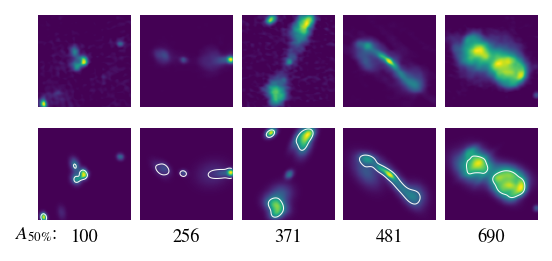

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import plotting.plot_images as pimg
reload(pimg)

a50 = metrics_dict["q0.5_area"]
n_examples = 5
_, bins = np.histogram(a50, bins=np.linspace(0, 800, n_examples + 1))


# Pick one random example from every bin
bin_idxs = np.digitize(a50, bins)
idxs = [np.random.choice(np.where(bin_idxs == i)[0])
        for i in range(1, n_examples + 1)]

reload(pplt)

fig, axs = pplt.pyBDSF_examples(
    [dset[i] for i in idxs],
    model_imgs[idxs],
    a50=True,
    
)

In [20]:
fig.savefig(pplt.out_path / "A50_examples.pdf", bbox_inches="tight")

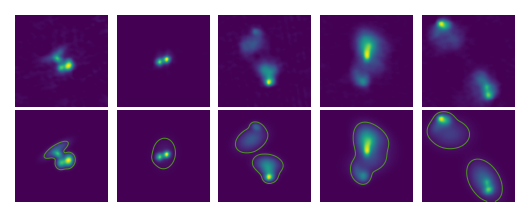

In [105]:
reload(pplt)

fig, axs = pplt.pyBDSF_examples(
    [dset[i] for i in idxs],
    model_imgs[idxs],
    a50=True,
)

In [104]:
import plotting.plot_images as pimg

reload(pimg)

<module 'plotting.plot_images' from '/home/bbd0953/diffusion/src/plotting/plot_images.py'>

## Flux Model Examples

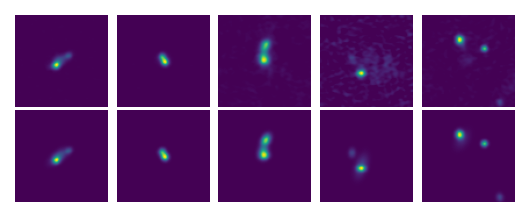

In [64]:
import plotting.paper_plots as pplt

reload(pplt)
import numpy as np

n_examples = 5
# idxs = np.random.choice(len(dset), n_examples, replace=False)

fig, ax = pplt.pyBDSF_examples(
    [dset[i] for i in idxs],
    model_imgs[idxs],
)

In [65]:
fig.savefig(pplt.out_path / "bdsf_examples.pdf", bbox_inches="tight")

# Selection Table

In [2]:
# Load cutouts
from utils.data_utils import EvaluationDataset
import utils.paths as paths

cutouts_path = Path(
    "/home/bbd0953/diffusion/image_data/LOFAR/cutouts/cutouts_80p_optC.hdf5"
)
dset = EvaluationDataset(cutouts_path, key="cutouts", catalog_keys=["Sigma_SNR"])

# Load catalog & remove problematic cutout entries
import h5py
import pandas as pd

cat = pd.read_hdf(cutouts_path, key="catalog")
dset.Sigma_SNR = dset.Sigma_SNR[~cat["Problem_cutout"]]

Loading images...
Data set initialized.


In [58]:
import numpy as np

catalog = cat[cat[f"Clipped_0sigma"]]
SNR_thr = 5
edge_thr = 0.8


# Problematic sources
print("\tProblematic sources:")
p_cols = [c for c in catalog.columns if "Problem" in c or "Nans" in c]
p_cat = catalog[p_cols]
print(*[f"\t{el}\n" for el in p_cat.sum().items()])
problem_mask = p_cat.sum(axis=1).astype(bool)
print(f"\t{problem_mask.sum():_} sources with problems.\n")
running_mask = problem_mask
print((~running_mask).sum())

# SNR threshold
SNR_mask = np.zeros(len(catalog), dtype=bool)
if SNR_thr is not None:
    print("\tSNR threshold:")
    SNR_mask = (catalog[f"Sigma_SNR"] < SNR_thr) & ~running_mask
    print(f"\t{SNR_mask.sum():_} sources below threshold.\n")
running_mask = running_mask | SNR_mask
print((~running_mask).sum())

# Edge threshold
print("\tEdge pixel threshold:")
edge_mask = (catalog["Edge_max"] > edge_thr) & ~running_mask
print(f"\t{edge_mask.sum():_} sources with edge pixels above threshold.\n")
running_mask = running_mask | edge_mask
print((~running_mask).sum())

# Broken images
print("\tBroken images:")
broken_mask = catalog["Broken_cutout"] & ~running_mask
print(f"\t{broken_mask.sum():_} sources with broken image.\n")
running_mask = running_mask | broken_mask
print((~running_mask).sum())

	Problematic sources:
	('Problem_cutout', 0)
 	('Nans_cutout', 668)
 	('Problem_clip', 0)
 	('Problem_resize', 0)
 	('Problem_norm', 653)

	1_228 sources with problems.

313714
	SNR threshold:
	201_322 sources below threshold.

112392
	Edge pixel threshold:
	5_319 sources with edge pixels above threshold.

107073
	Broken images:
	286 sources with broken image.

106787


In [61]:
import tabulate

table = {
    "Step": ["Cutouts", "Broken", "SNR", "Edge Pixels", "Incomplete", "Total"],
    "Dropouts": [
        "...",
        problem_mask.sum(),
        SNR_mask.sum(),
        edge_mask.sum(),
        broken_mask.sum(),
        running_mask.sum(),
    ],
}
table["Selected"] = [
    len(catalog),
]
for i, el in enumerate(table["Dropouts"][1:-1], start=1):
    table["Selected"].append(table["Selected"][i - 1] - el)
table["Selected"].append(table["Selected"][0] - table["Dropouts"][-1])

# Add \num{...} formatting to all numbers in the table
for k, v in table.items():
    table[k] = [f"\\num{{{el}}}" if not isinstance(
        el, str) else el for el in v]

print(
    tabulate.tabulate(
        table,
        headers="keys",
        tablefmt="latex_raw",
        numalign="center",
        stralign="center",
    ),
)

\begin{tabular}{ccc}
\hline
    Step     &   Dropouts   &   Selected   \\
\hline
   Cutouts   &     ...      & \num{314942} \\
   Broken    &  \num{1228}  & \num{313714} \\
     SNR     & \num{201322} & \num{112392} \\
 Edge Pixels &  \num{5319}  & \num{107073} \\
 Incomplete  &  \num{286}   & \num{106787} \\
    Total    & \num{208155} & \num{106787} \\
\hline
\end{tabular}


# Sigma-SNR examples

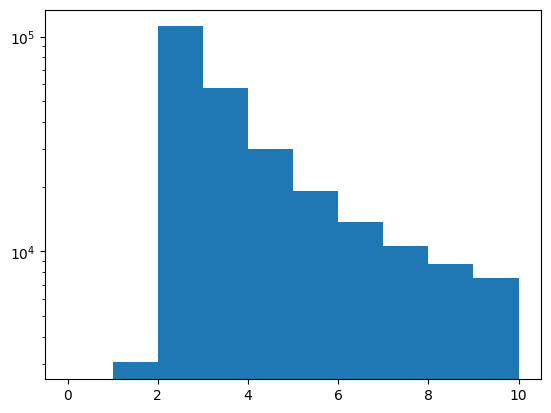

In [3]:
import numpy as np

plt.hist(dset.Sigma_SNR, bins=np.arange(0, 11, 1))
plt.yscale("log")
plt.show()

In [4]:
# Create subset
import copy

subset = copy.deepcopy(dset)
# subset.index_slice(dset.Sigma_SNR <= 10)

8


/hs/fs08/data/group-brueggen/tmartinez/envs/cenv_diffusion/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


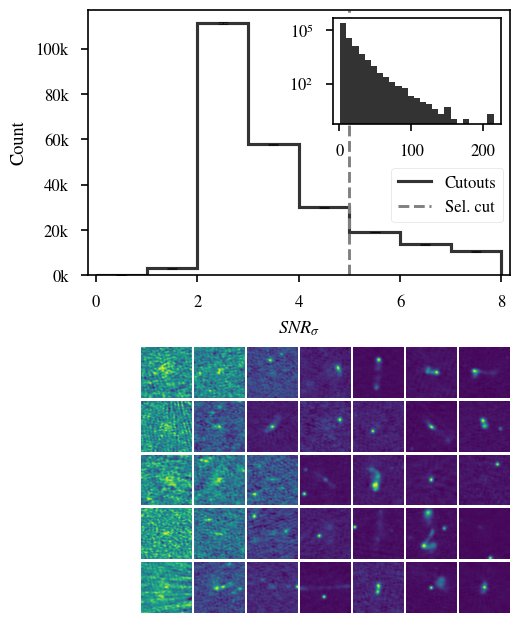

/hs/fs08/data/group-brueggen/tmartinez/envs/cenv_diffusion/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.manager.handle_json(content)
/hs/fs08/data/group-brueggen/tmartinez/envs/cenv_diffusion/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.manager.handle_json(content)


In [14]:
import numpy as np
import plotting.plot_utils as pltu

reload(pltu)
import plotting.paper_plots as pplt

reload(pplt)

%matplotlib widget

fig = pplt.SNR_example_plot(
    subset.Sigma_SNR,
    edges=np.arange(0, 9, 1),
    images=[x for x in subset],
)

In [15]:
reload(pplt)
fig.savefig(pplt.out_path / "Sigma-SNR_examples.pdf")

/tmp/ipykernel_2564811/1039889130.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(pplt.out_path / "Sigma-SNR_examples.pdf")


# Selection Dropouts examples

In [23]:
cat = cat[~cat["Problem_cutout"]]

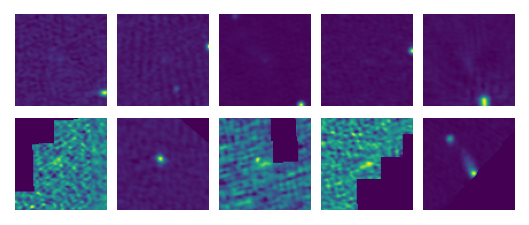

In [41]:
reload(pplt)

edge_thr = 0.8
SNR_thr = 5
SNR_mask = cat[f"Sigma_SNR"] < SNR_thr
edge_mask = (cat["Edge_max"] > edge_thr) & ~SNR_mask
broken_mask = cat["Broken_cutout"] & ~edge_mask

"""
# Select 5 random examples from each category
edge_imgs = [
    dset[i] for i in np.random.choice(np.where(edge_mask)[0], 5)
]


broken_imgs = [
    dset[i] for i in np.random.choice(np.where(broken_mask)[0], 5)
]
"""

# Plot examples
fig, ax = pplt.selection_dropout_plot(edge_imgs, broken_imgs)

In [42]:
fig.savefig(pplt.out_path / "dropout_examples.pdf", bbox_inches="tight")

# Selected Images

In [16]:
dset_sel = EvaluationDataset(paths.LOFAR_SUBSETS["0-clip"])

Loading images...
Data set initialized.


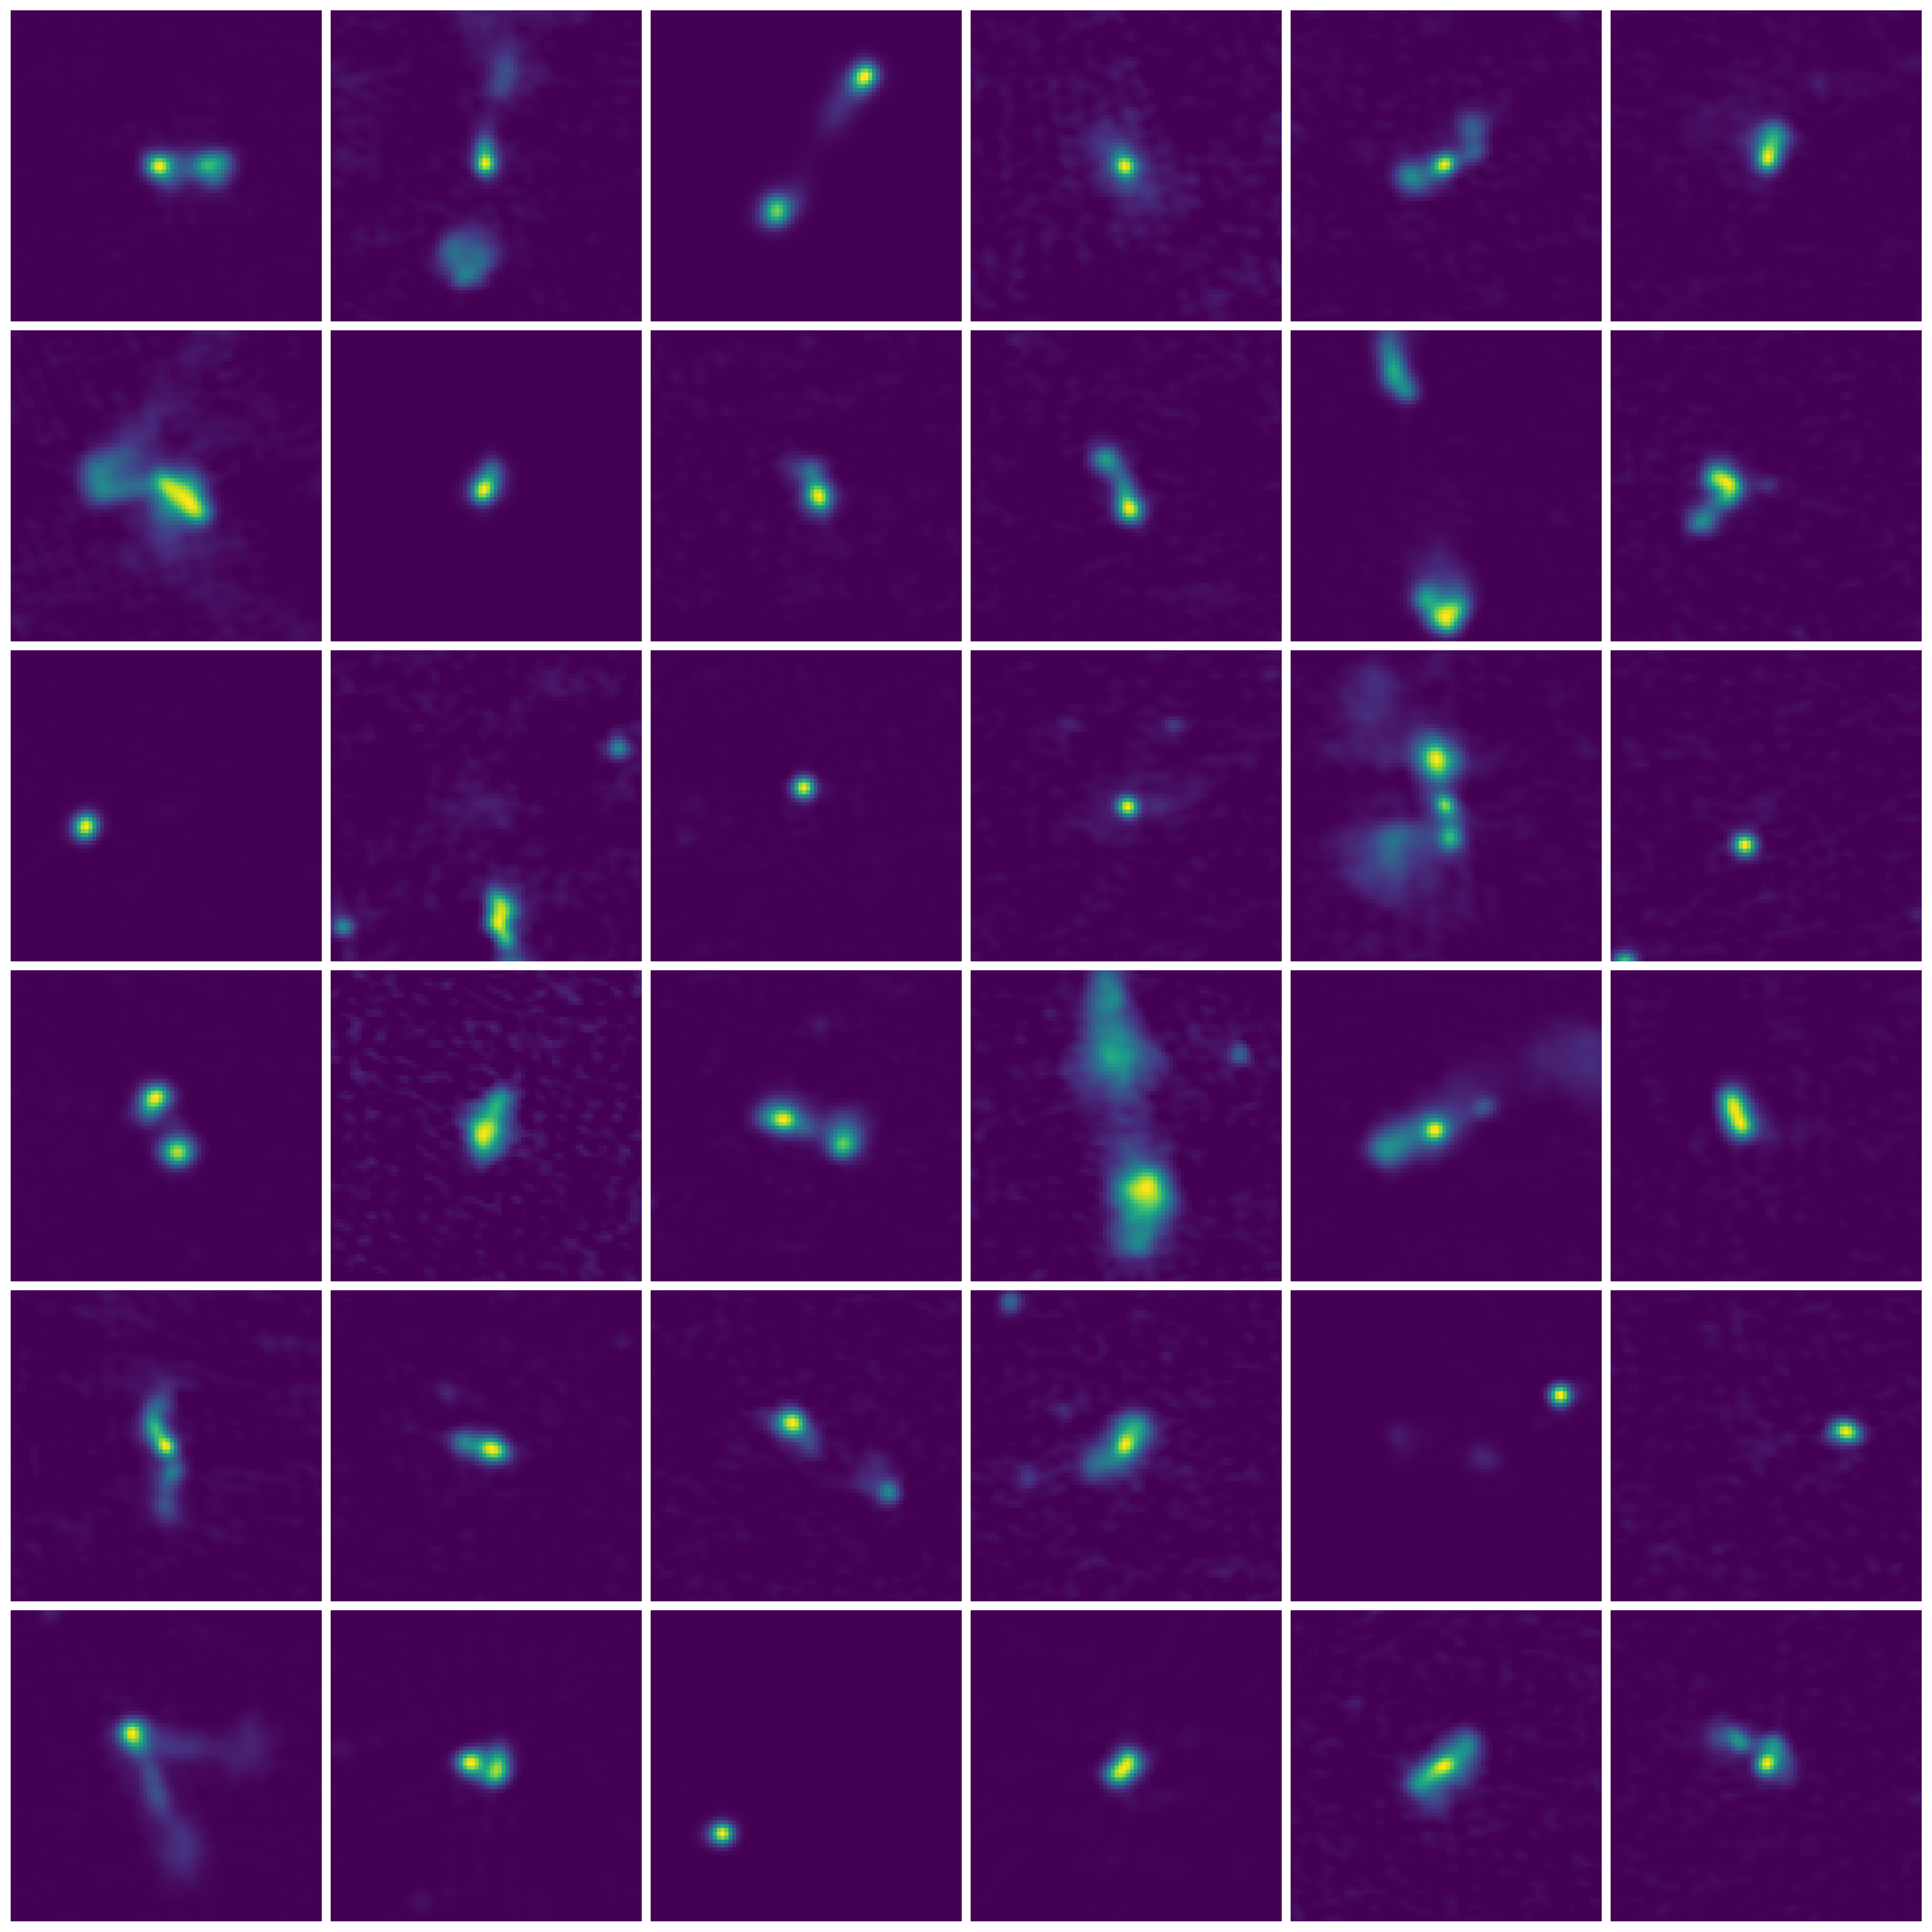

In [76]:
from plotting.plot_images import random_image_grid

fig, ax = random_image_grid(dset_sel, 36)

In [77]:
fig.savefig(pplt.out_path / "selection_plot.pdf", bbox_inches="tight")

# Box-Cox Transform

In [78]:
dset_sel.transform_max_vals()

Max values transformed with Box-Cox transformation ([-0.22999055]).


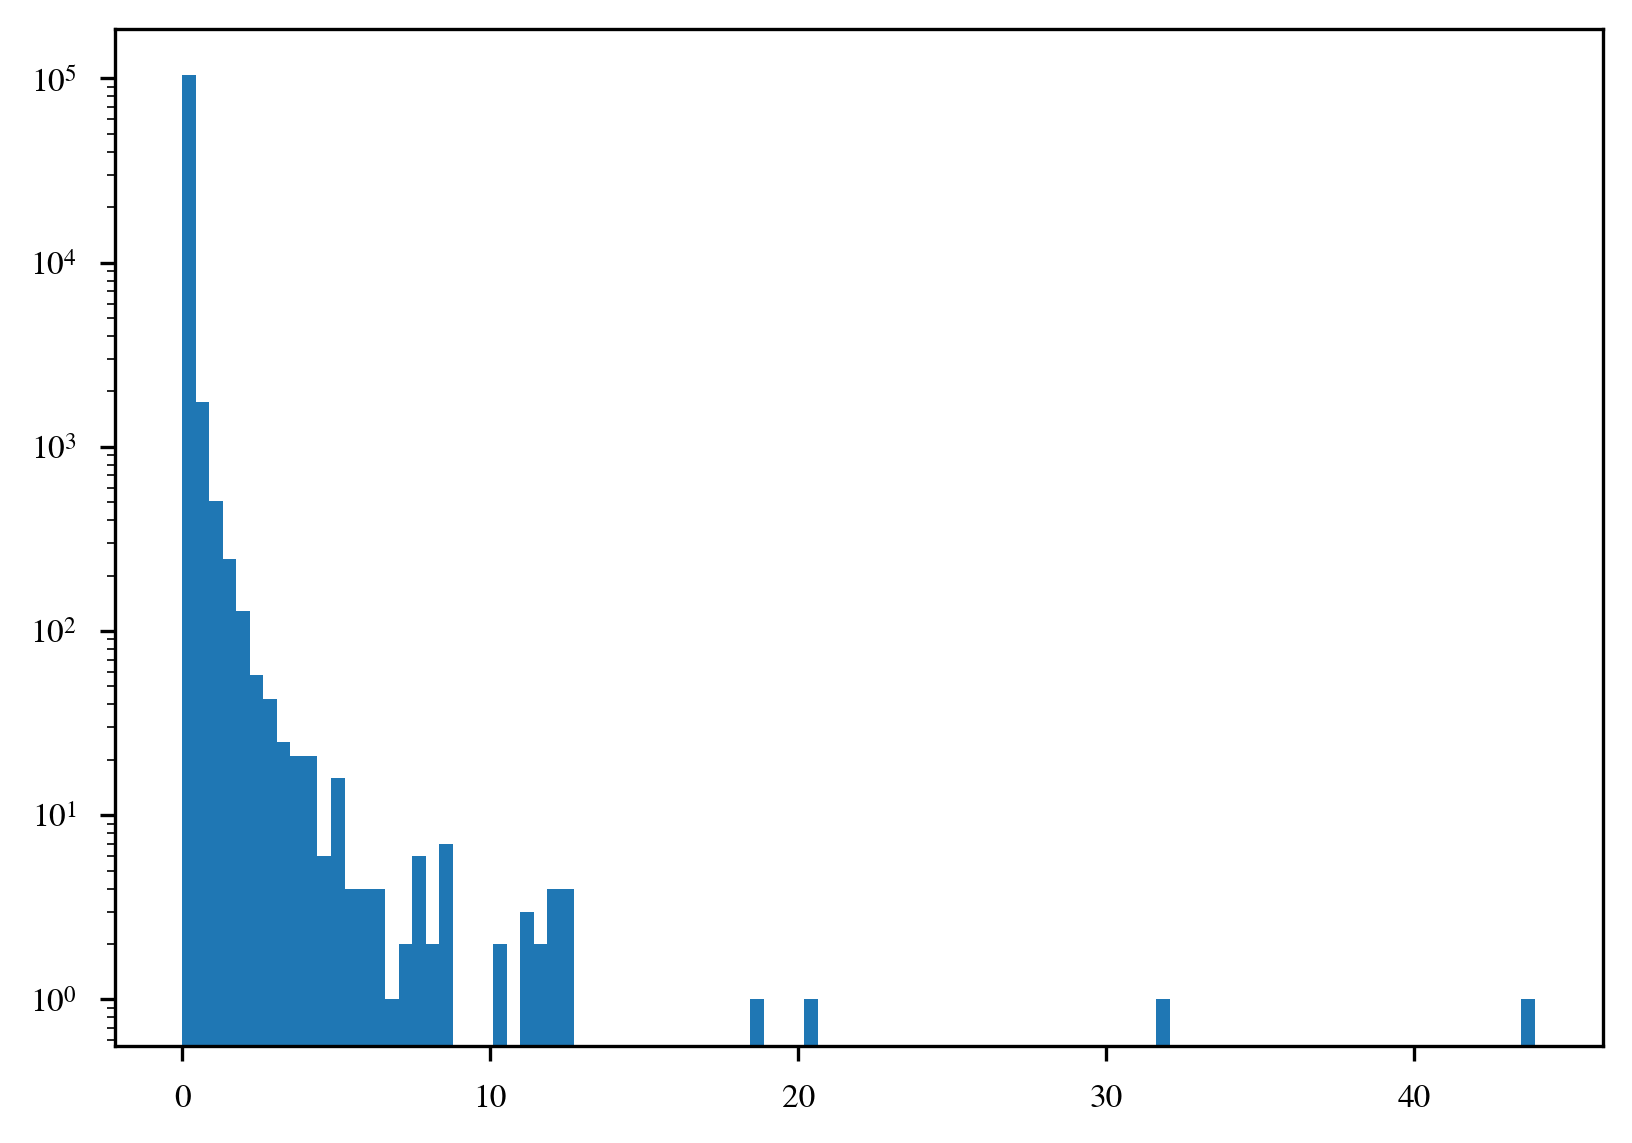

In [85]:
plt.hist(dset_sel.max_values, bins=100)
plt.yscale("log")
plt.show()

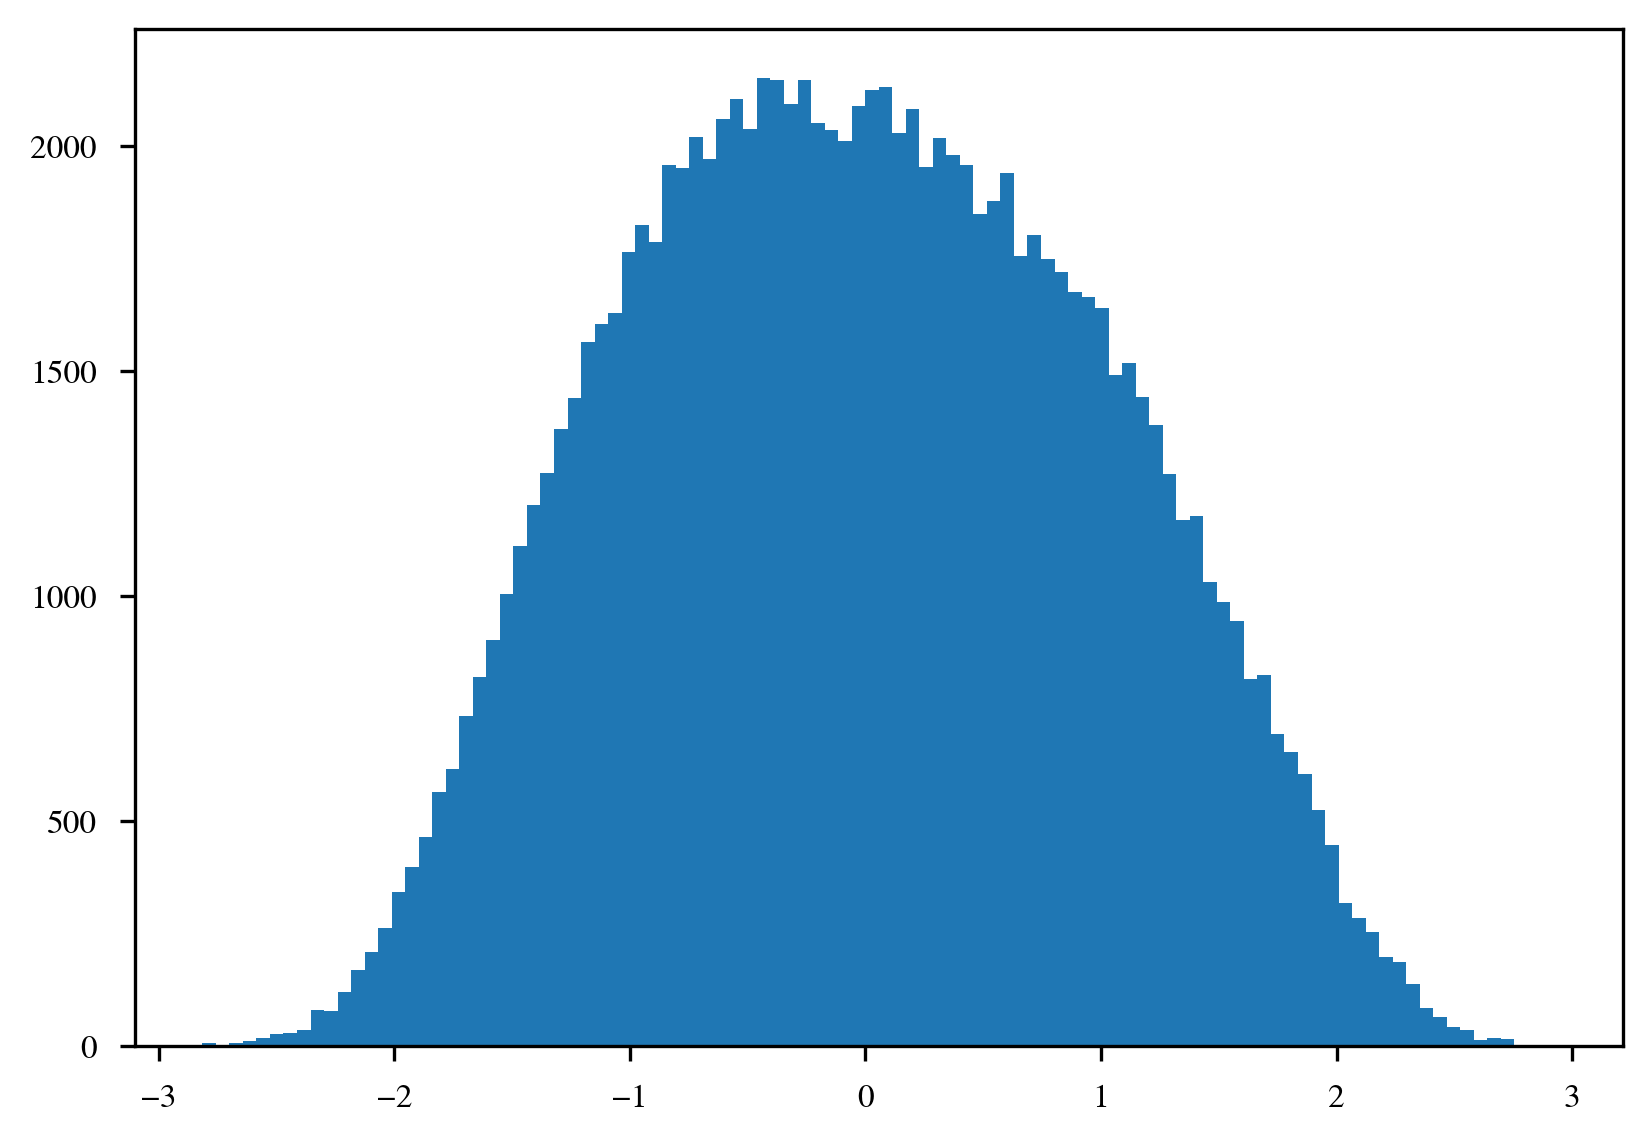

In [87]:
plt.hist(dset_sel.max_values_tr, bins=100)
plt.show()

Max values transformed with Box-Cox transformation ([-0.22999055]).


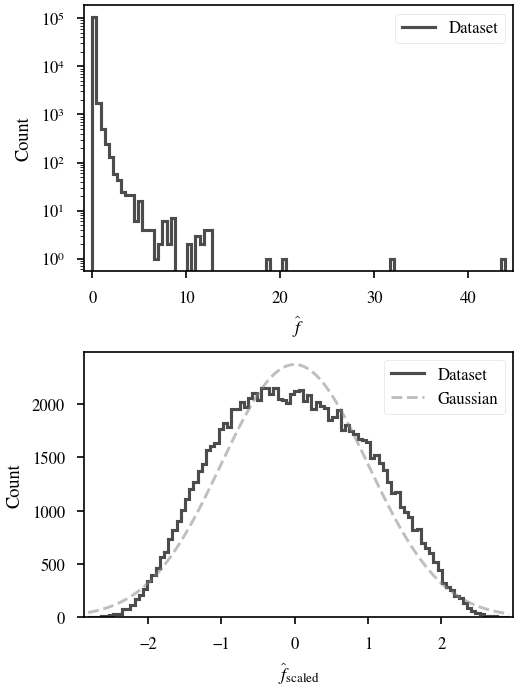

In [20]:
reload(pltu)
reload(pplt)

fig, ax = pplt.boxcox_plot(dset_sel)

In [21]:
fig.savefig(pplt.out_path / "boxcox_plot.pdf", bbox_inches="tight")

# FIRST Examples

/home/bbd0953/diffusion/src/datasets/firstgalaxydata.py:350: UserWarning: Could not find masking parameters, only available for LOFAR data. mask_param will be None.
  warnings.warn(


Removing images where all pixels are zero after transform...
	Removed 0 images.
Removing images where all pixels are zero after transform...
	Removed 0 images.
Removing images where all pixels are zero after transform...
	Removed 0 images.
Removing images where all pixels are zero after transform...
	Removed 0 images.


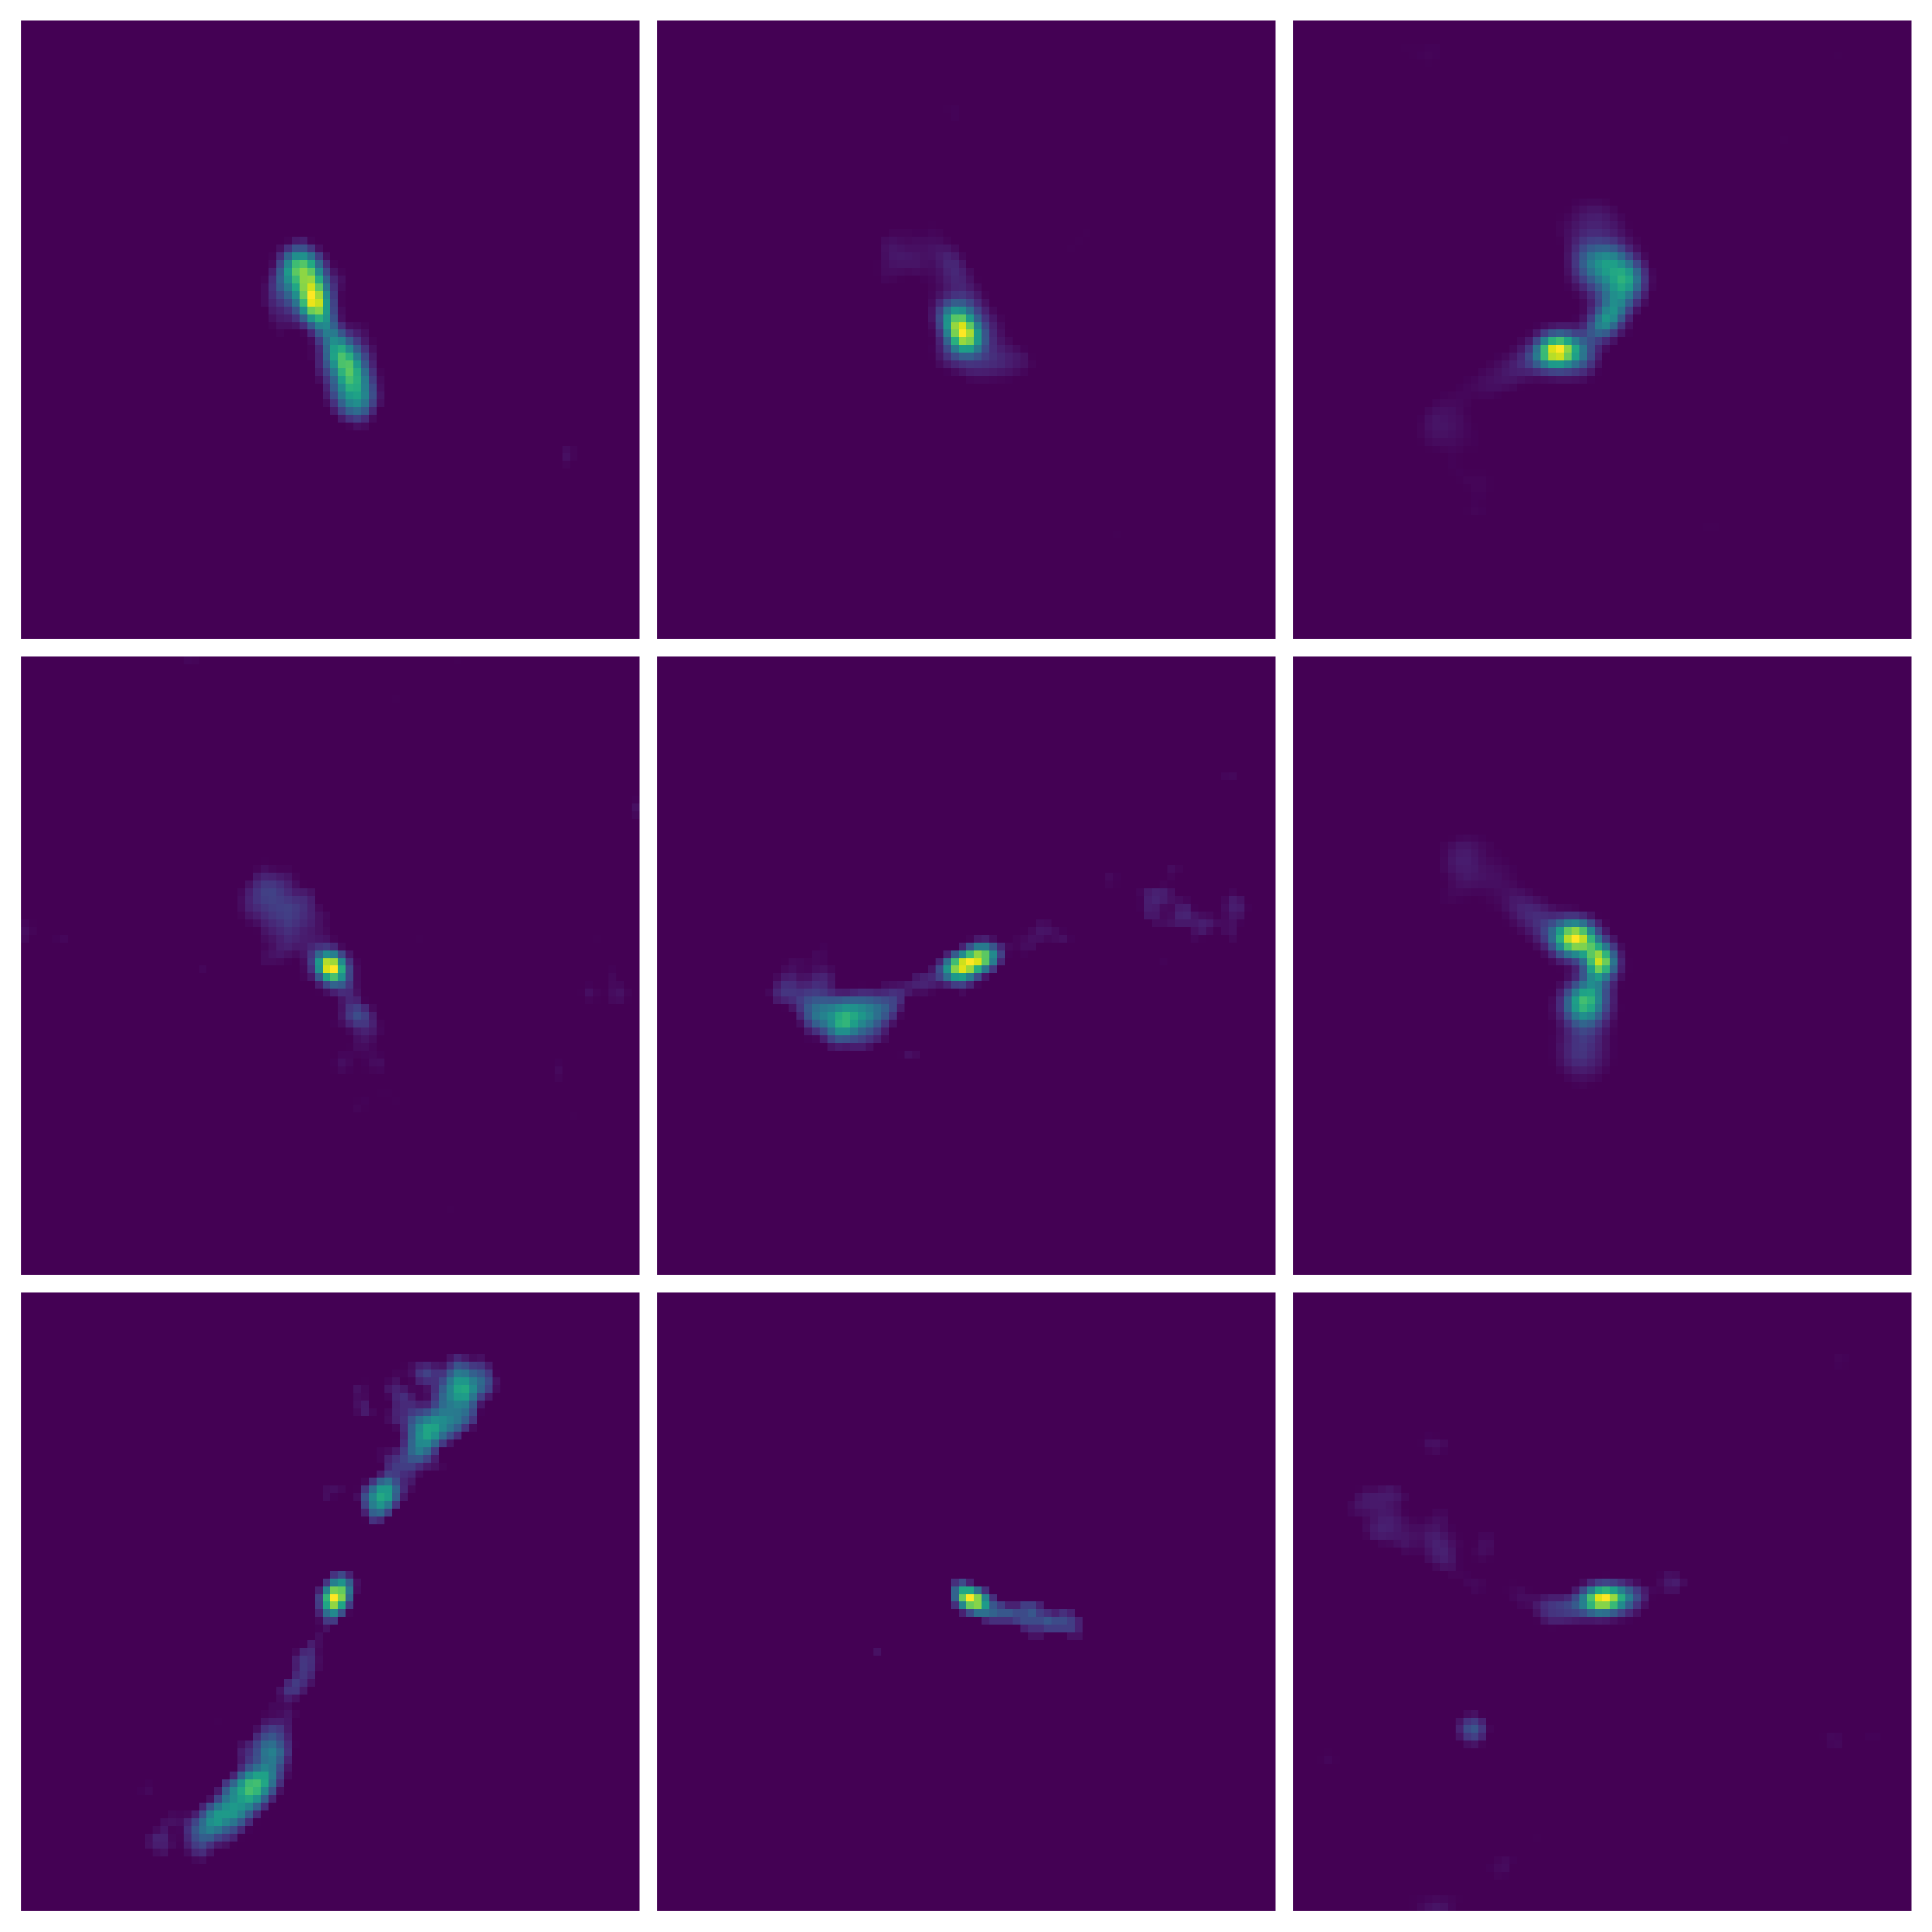

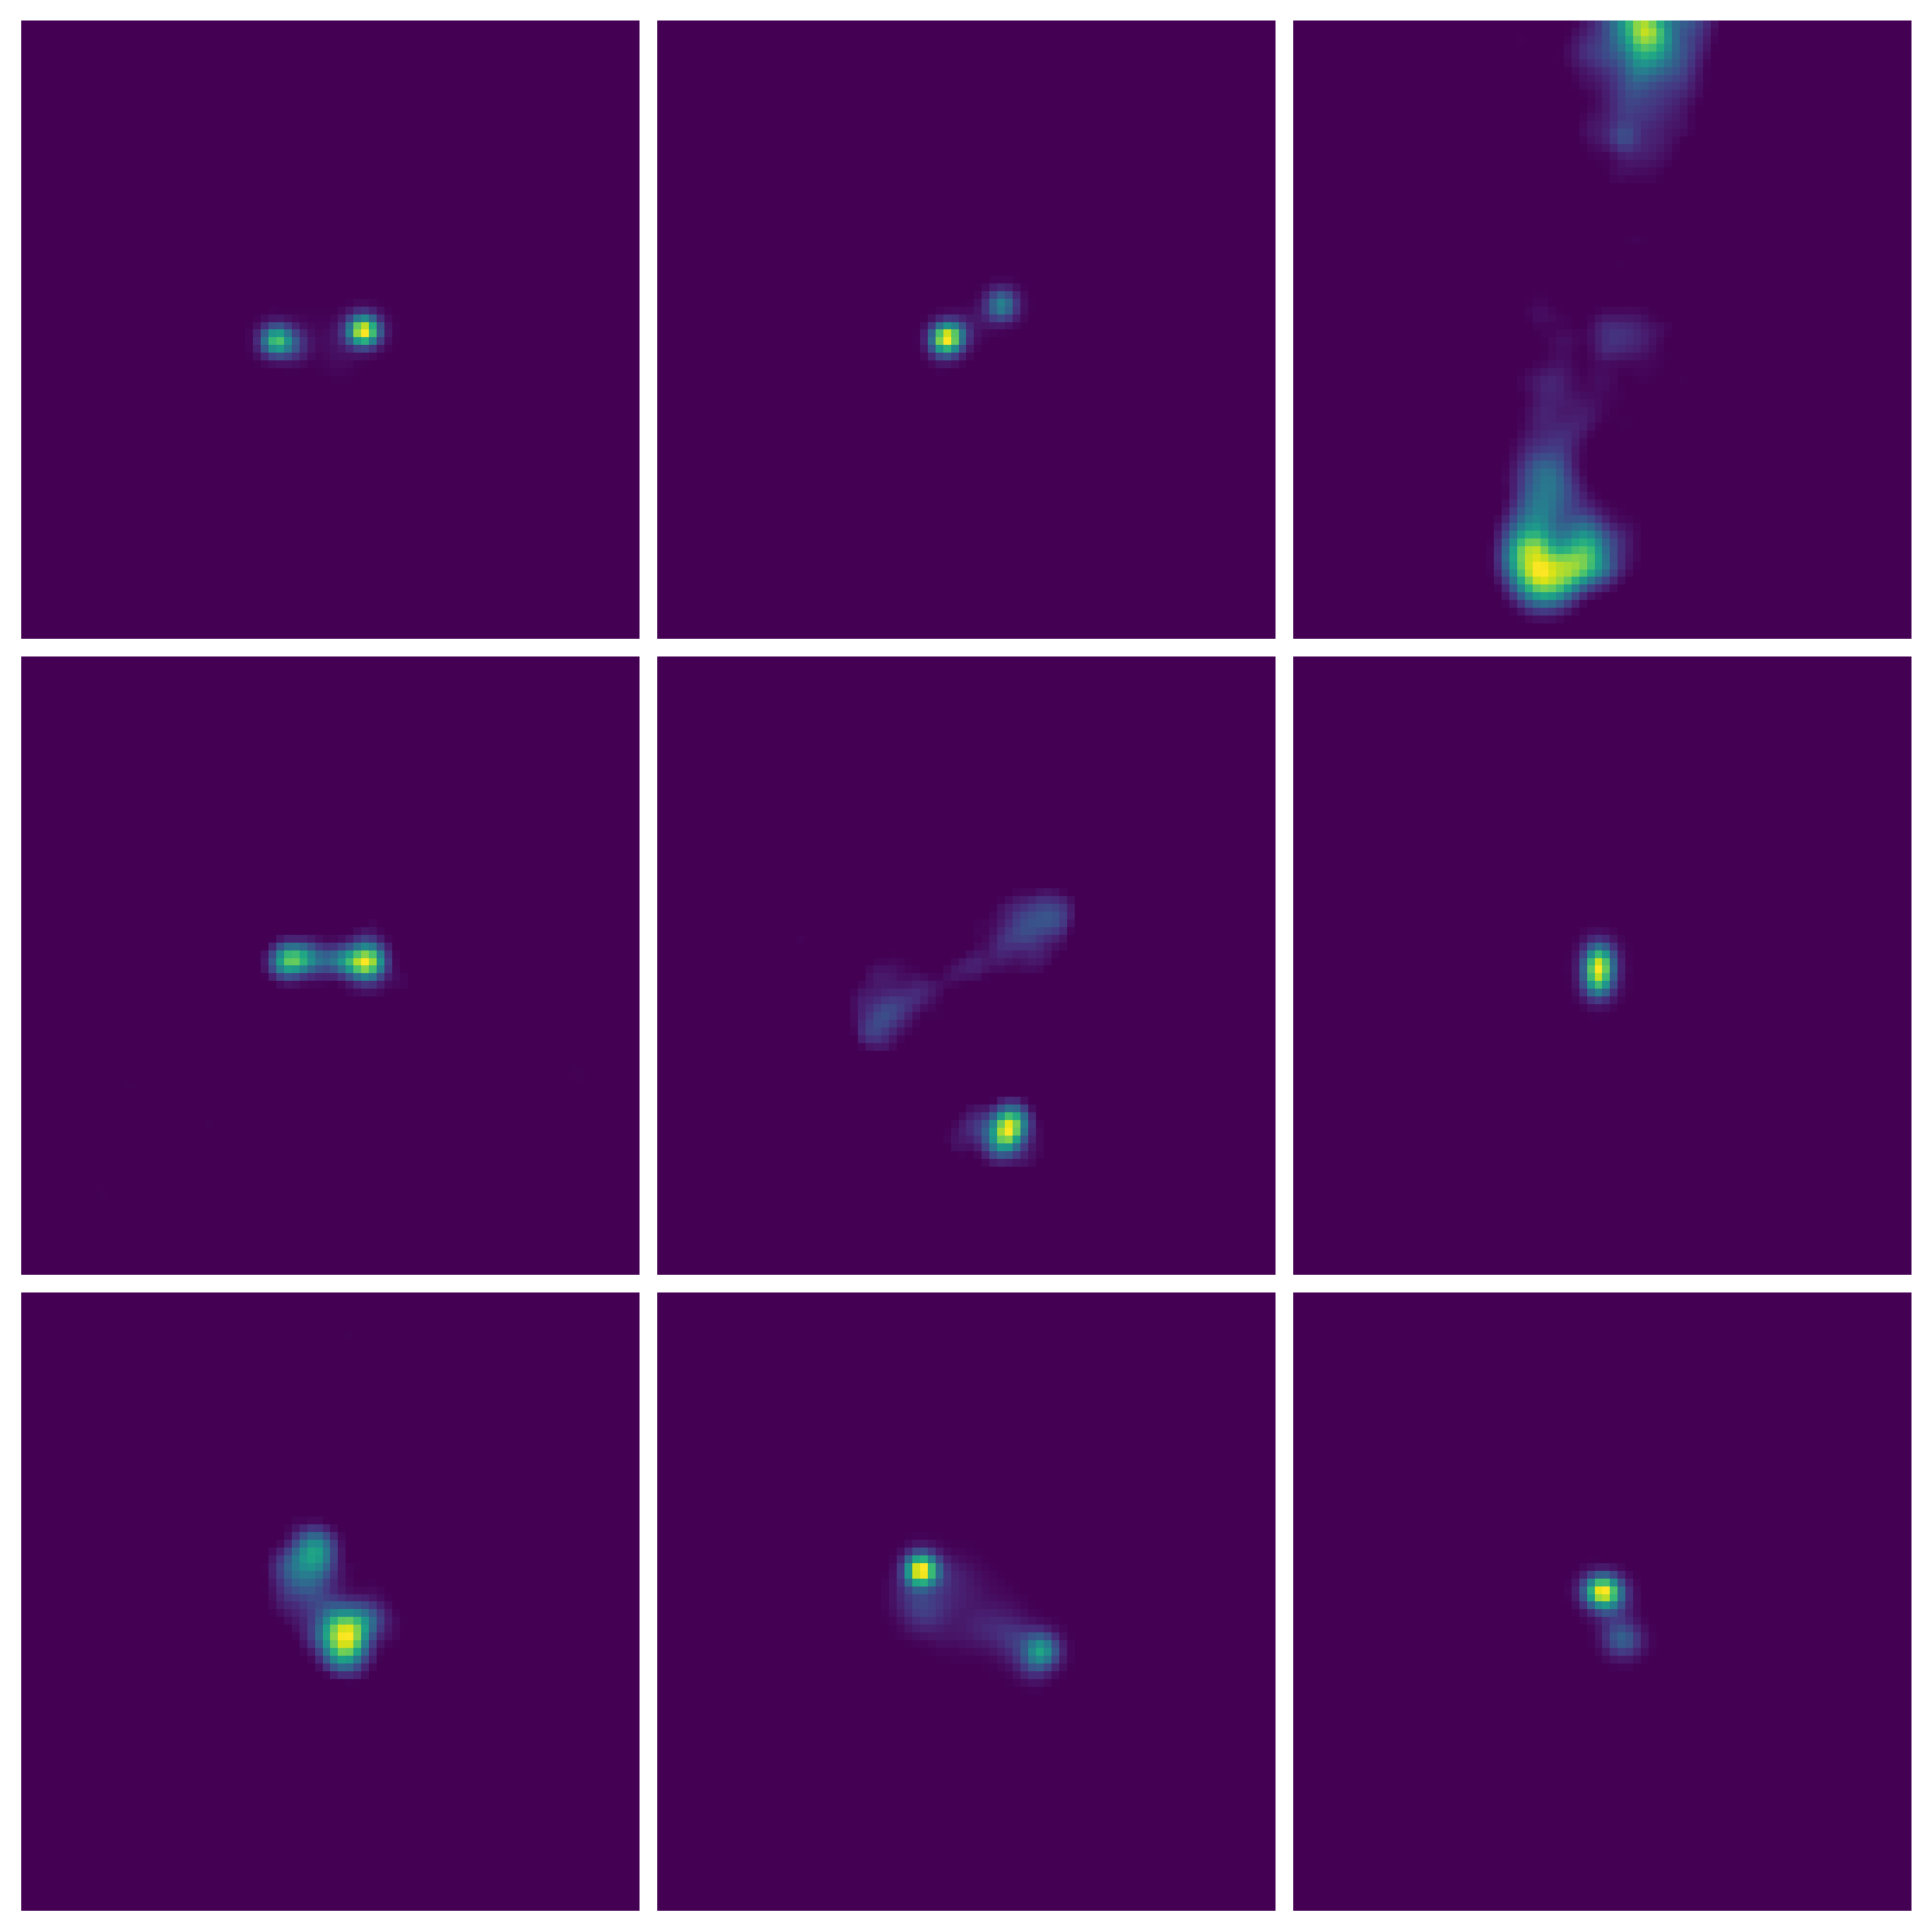

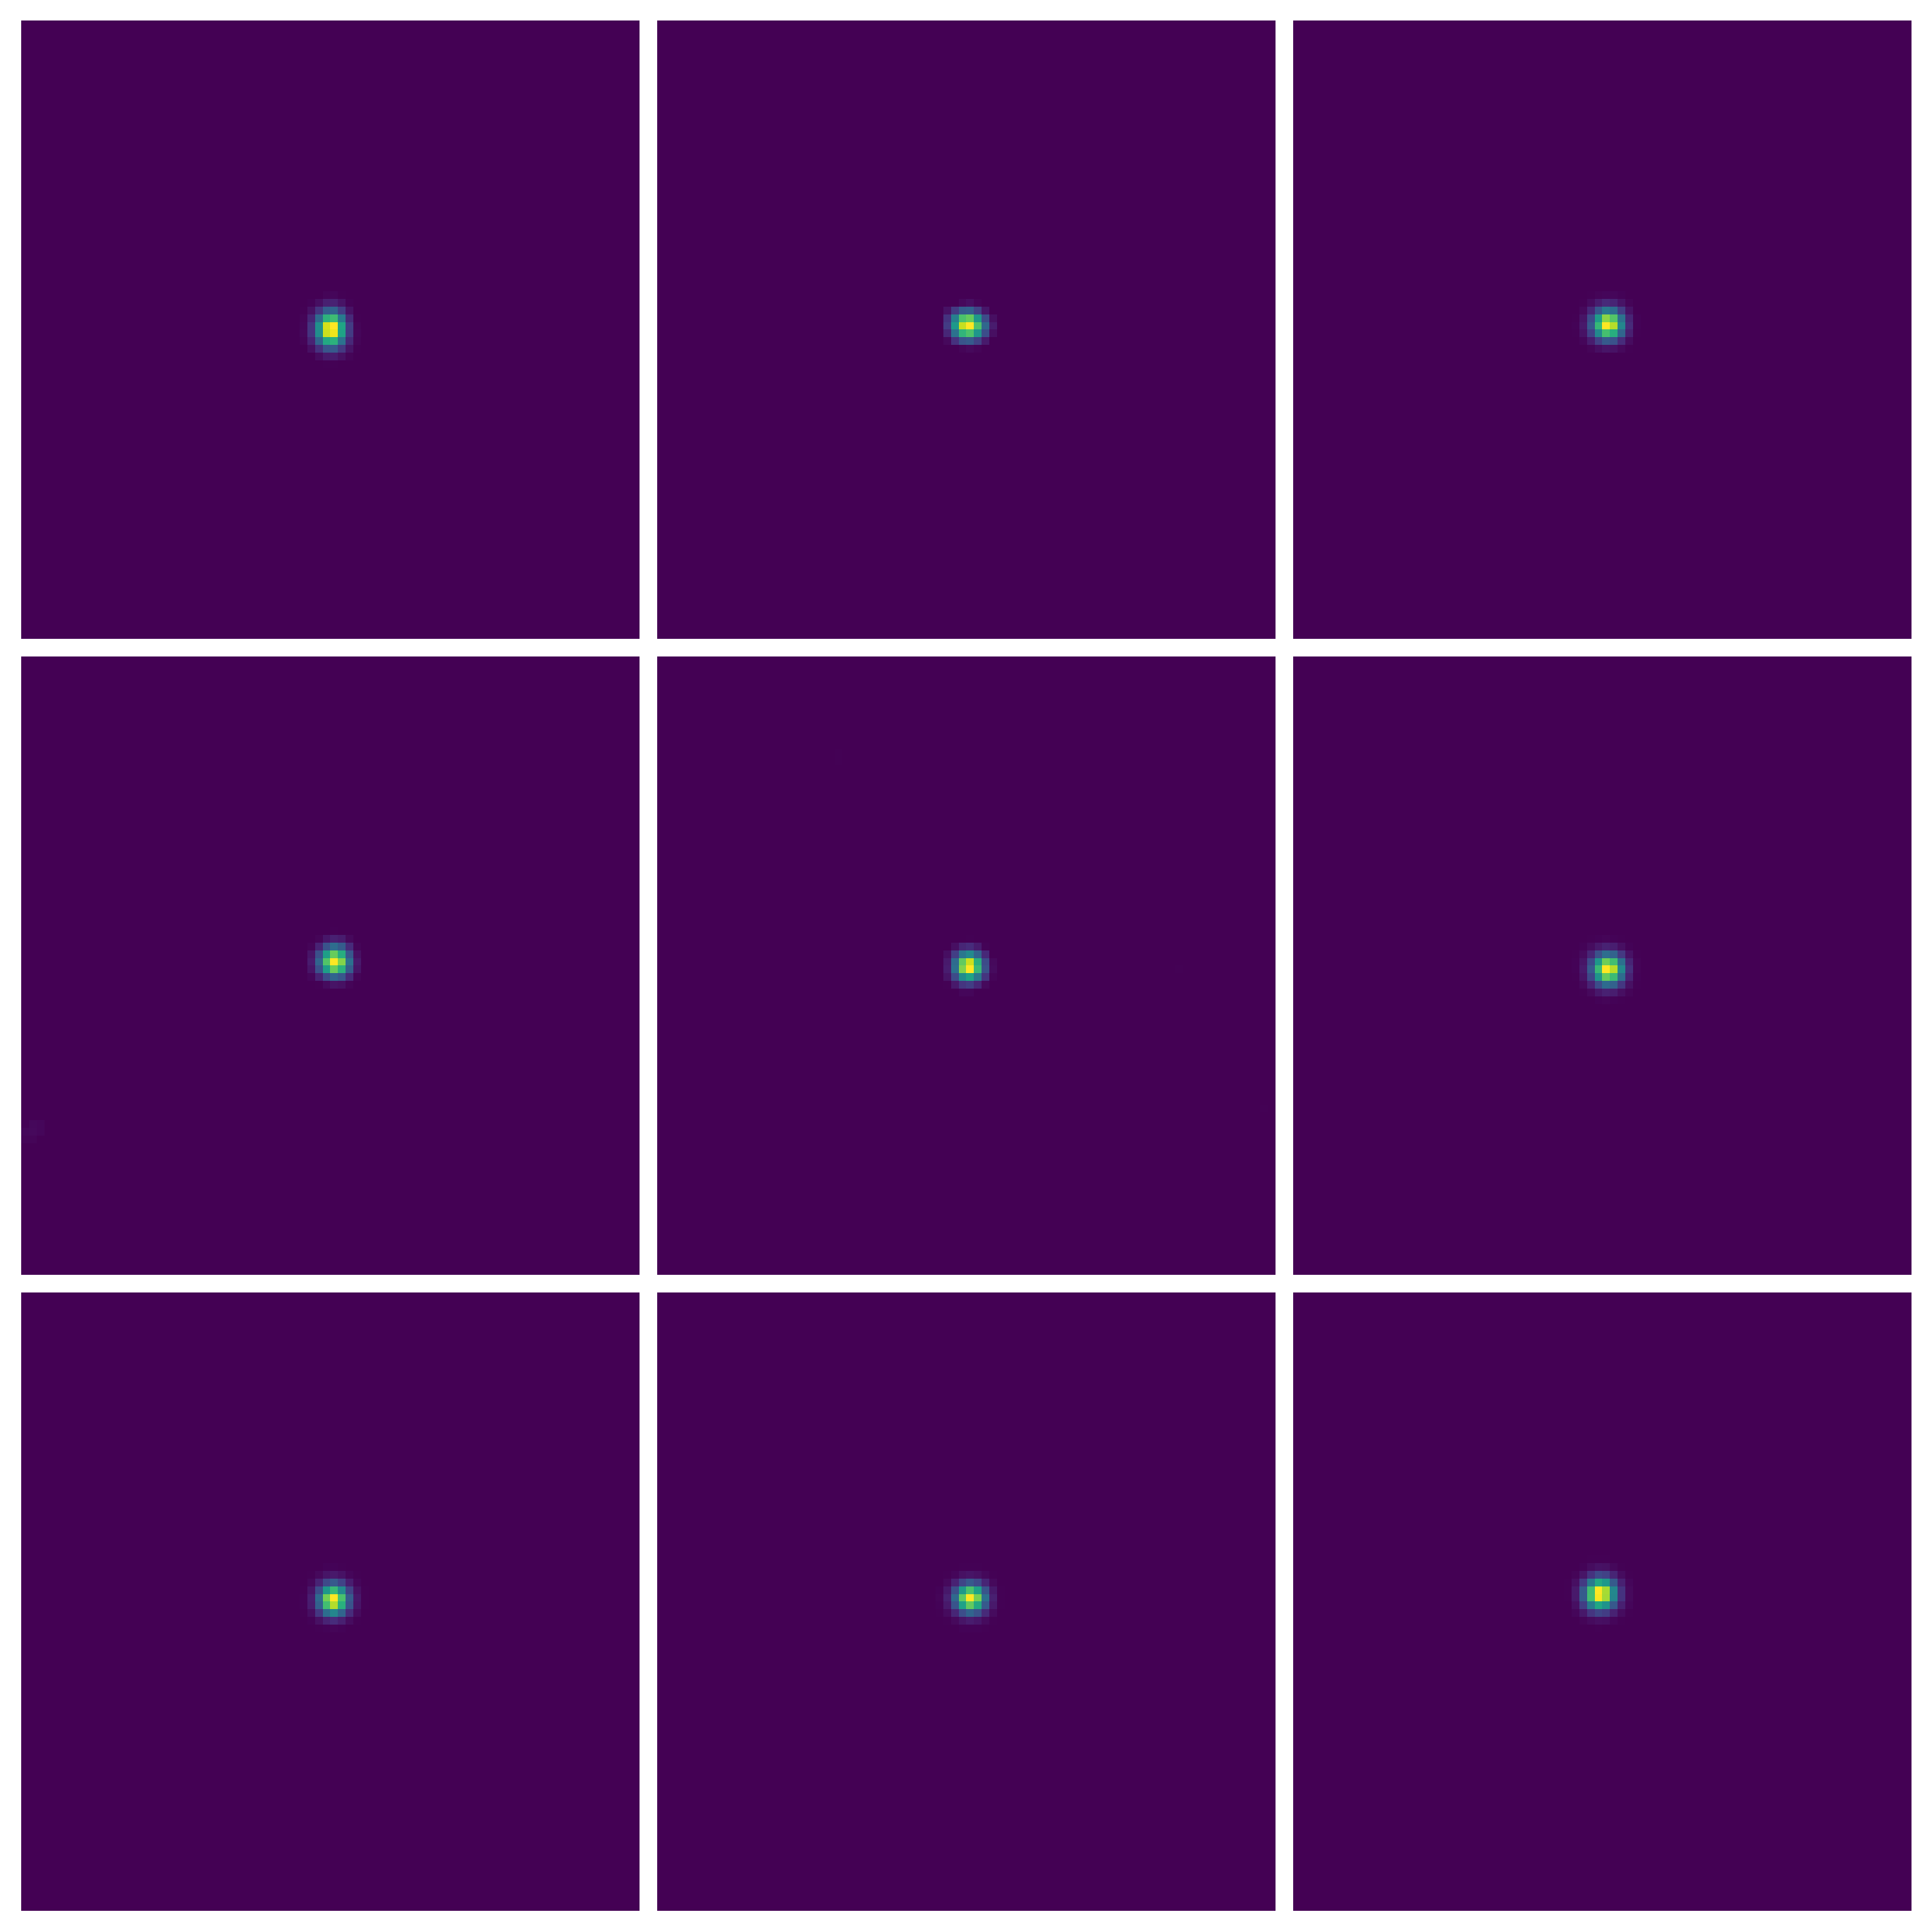

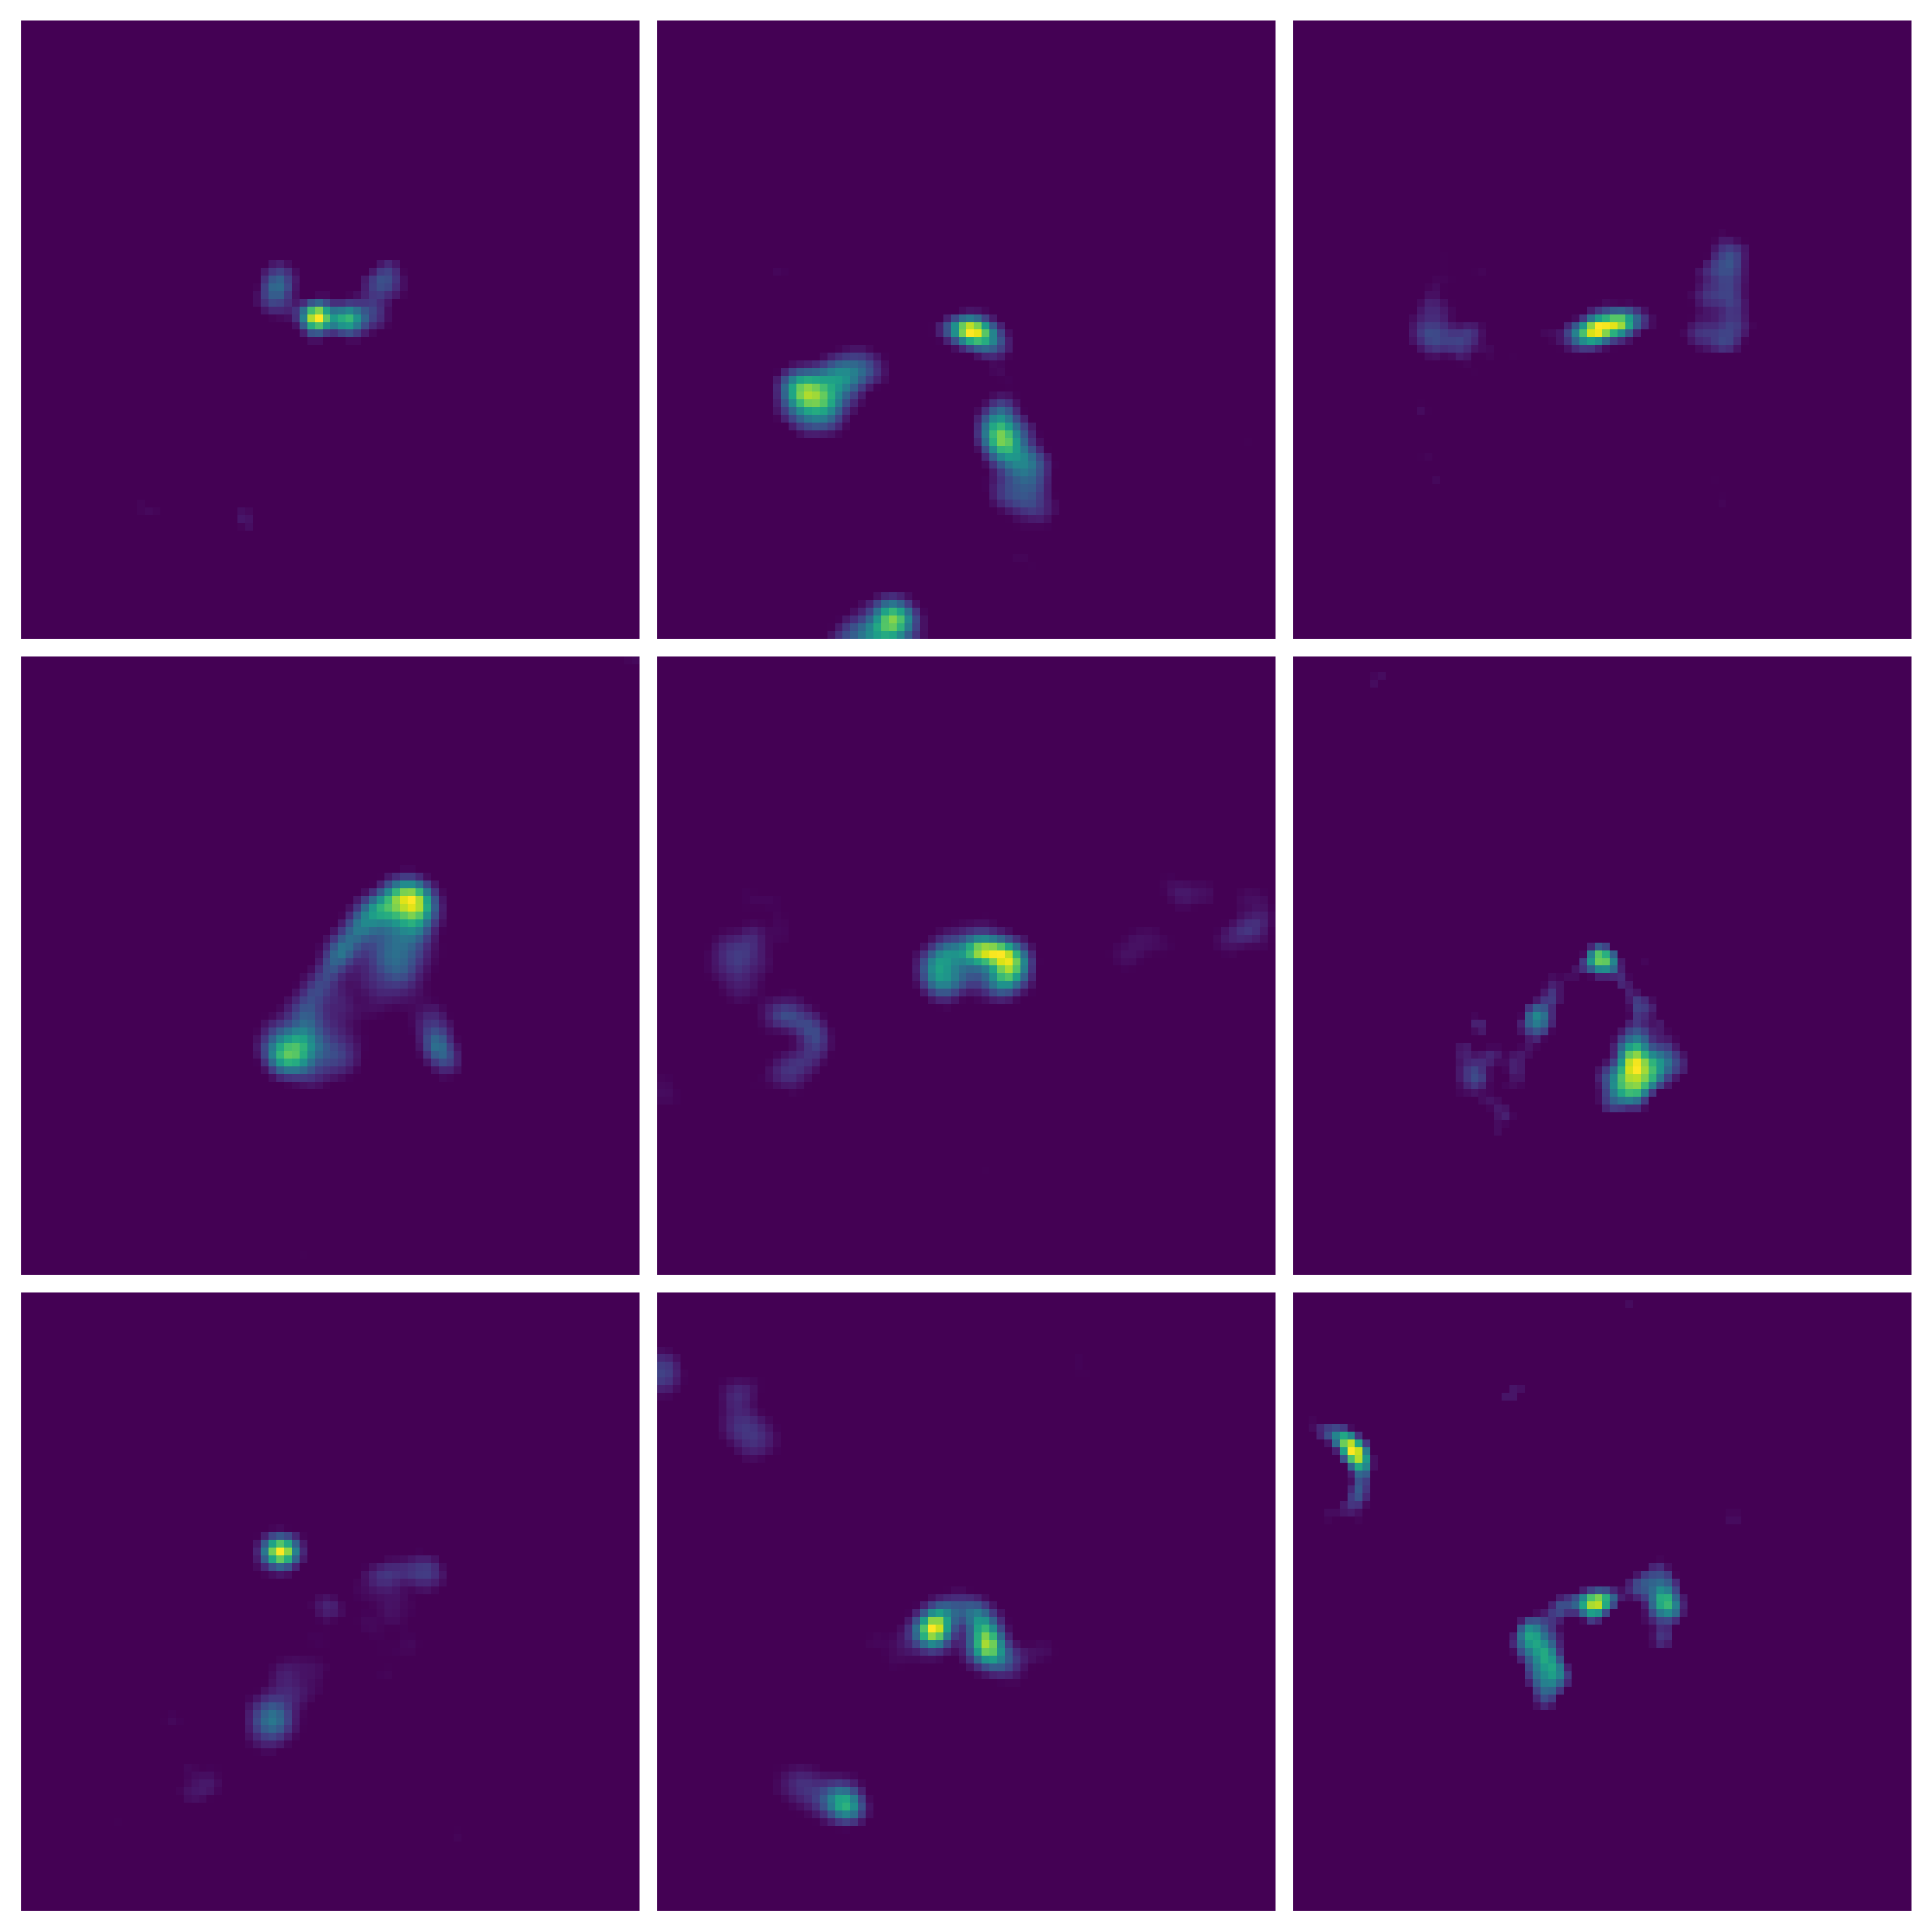

In [132]:
import plotting.plot_images as plti

reload(plti)
import utils.data_utils as du

reload(du)
classes = ["FRI", "FRII", "Compact", "Bent"]
figs = []
for cls in classes:
    cls_set = du.TrainDatasetFIRST(selected_classes=[cls])
    fig, _ = plti.random_image_grid(cls_set, 9, vmin=-1)
    fig.show()
    figs.append(fig)

In [133]:
for fig, cls in zip(figs, classes):
    fig.savefig(pplt.out_path / f"FIRST_{cls}_examples.pdf", bbox_inches="tight")